比赛的网址是 https://www.kaggle.com/c/cifar-10

In [4]:
!pip install d2l
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [5]:
#13.9.1.1. 下载数据集
#为了便于入门，我们提供包含前 1000 个训练图像和 5 个随机测试图像的数据集的小规模样本。 
#要使用 Kaggle 竞赛的完整数据集，你需要将以下 demo 变量设置为 False。
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果你使用完整的Kaggle竞赛的数据集，设置`demo`为 False
demo = True

if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

In [6]:
#13.9.1.2. 整理数据集
#我们需要整理数据集来训练和测试模型。 
#首先，我们用以下函数读取 csv 文件中的标签，它返回一个字典，该字典将文件名中不带扩展名的部分映射到其标签。
def read_csv_labels(fname):
    """读取 `fname` 来给标签字典返回一个文件名。"""
    with open(fname, 'r') as f:
        # 跳过文件头行 (列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练示例 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练示例 : 1000
# 类别 : 10


In [7]:
#接下来，我们定义 reorg_train_valid 函数来将验证集从原始的训练集中拆分出来。 
#此函数中的参数 valid_ratio 是验证集中的示例数与原始训练集中的示例数之比。 
#更具体地说，令  n  等于示例最少的类别中的图像数量，而  r  是比率。 
#验证集将为每个类别拆分出  max(⌊nr⌋,1)  张图像。 让我们以 valid_ratio=0.1 为例，
#由于原始的训练集有 50000 张图像，因此 train_valid_test/train 路径中将有 45000 张图像用于训练，
#而剩下 5000 张图像将作为路径 train_valid_test/valid 中的验证集。 组织数据集后，同类别的图像将被放置在同一文件夹下。
def copyfile(filename, target_dir):
    """将文件复制到目标目录。"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    # 训练数据集中示例最少的类别中的示例数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的示例数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(
            fname,
            os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(
                fname,
                os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

In [8]:
#下面的 reorg_test 函数用来在预测期间整理测试集，以方便读取。
def reorg_test(data_dir):
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(
            os.path.join(data_dir, 'test', test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

In [9]:
#最后，我们使用一个函数来调用前面定义的函数 read_csv_labels 、 reorg_train_valid 和 reorg_test 。
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [10]:
#在这里，我们只将样本数据集的批量大小设置为 32。 在实际训练和测试中，应该使用 Kaggle 竞赛的完整数据集，
#并将 batch_size 设置为更大的整数，例如 128。 我们将 10％ 的训练示例作为调整超参数的验证集。
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [11]:
#13.9.2. 图像增广
#我们使用图像增广来解决过拟合的问题。例如在训练中，我们可以随机水平翻转图像。 
#我们还可以对彩色图像的三个 RGB 通道执行标准化。 下面，我们列出了其中一些可以调整的操作
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64到1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                             ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [12]:
#在测试期间，我们只对图像执行标准化，以消除评估结果中的随机性。
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [13]:
#13.9.3. 读取数据集
#接下来，我们读取由原始图像组成的数据集，每个示例都包括一张图片和一个标签。
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]

In [14]:
#在训练期间，我们需要指定上面定义的所有图像增广操作。 
#当验证集在超参数调整过程中用于模型评估时，不应引入图像增广的随机性。 
#在最终预测之前，我们根据训练集和验证集组合而成的训练模型进行训练，以充分利用所有标记的数据。
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [15]:
#13.9.4. 定义模型
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

In [16]:
#13.9.5. 定义训练函数¶
#我们将根据模型在验证集上的表现来选择模型并调整超参数。 下面我们定义了模型训练函数 train。
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss,
                                          trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.646, train acc 0.786, valid acc 0.453
916.7 examples/sec on [device(type='cuda', index=0)]


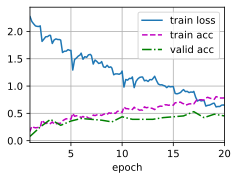

In [17]:
#13.9.6. 训练和验证模型
#现在，我们可以训练和验证模型了，而以下所有超参数都可以调整。 
#例如，我们可以增加周期的数量。当 lr_period 和 lr_decay 分别设置为 4 和 0.9 时，
#优化算法的学习速率将在每 4 个周期乘以 0.9。 为便于演示，我们在这里只训练 20 个周期。
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

train loss 0.672, train acc 0.766
926.8 examples/sec on [device(type='cuda', index=0)]


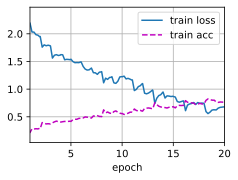

In [18]:
#13.9.7. 在 Kaggle 上对测试集进行分类并提交结果
#在获得具有超参数的满意的模型后，我们使用所有标记的数据（包括验证集）来重新训练模型并对测试集进行分类。
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)